# Imports and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, average_precision_score
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
import warnings
from datetime import timedelta
from user_agents import parse
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_parquet("train.parquet", engine='pyarrow')
test = pd.read_parquet("test.parquet", engine='pyarrow')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17499636 entries, 0 to 25661583
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 2.6+ GB


In [4]:
print("Test shape:", test.shape)
print("\nTest info:")
test.info()
print("\nTrain unique users:", train['userId'].nunique())
print("Test unique users:", test['userId'].nunique())
print("\nTrain date range:", train['time'].min(), "to", train['time'].max())
print("Test date range:", test['time'].min(), "to", test['time'].max())
print("\nPages in train:", train['page'].value_counts())

Test shape: (4393179, 19)

Test info:
<class 'pandas.core.frame.DataFrame'>
Index: 4393179 entries, 7 to 25661314
Data columns (total 19 columns):
 #   Column         Dtype         
---  ------         -----         
 0   status         int64         
 1   gender         object        
 2   firstName      object        
 3   level          object        
 4   lastName       object        
 5   userId         object        
 6   ts             int64         
 7   auth           object        
 8   page           object        
 9   sessionId      int64         
 10  location       object        
 11  itemInSession  int64         
 12  userAgent      object        
 13  method         object        
 14  length         float64       
 15  song           object        
 16  artist         object        
 17  time           datetime64[us]
 18  registration   datetime64[us]
dtypes: datetime64[us](2), float64(1), int64(4), object(12)
memory usage: 670.3+ MB

Train unique users: 19140
Test un

# Churn prediction pipeline

## 1. Preprocessing & Parsing UserAgent

In [5]:
def parse_user_agent(ua_string):
    if pd.isna(ua_string):
        return {'is_mobile': 0, 'os_family': 'Unknown', 'browser_family': 'Unknown'}
    
    try:
        ua = parse(ua_string)
        return {
            'is_mobile': 1 if ua.is_mobile else 0,
            'os_family': ua.os.family if ua.os.family else 'Unknown',
            'browser_family': ua.browser.family if ua.browser.family else 'Unknown'
        }
    except:
        return {'is_mobile': 0, 'os_family': 'Unknown', 'browser_family': 'Unknown'}

def preprocess_data(df):
    df = df.copy()
    
    print("Parsing userAgent...")
    unique_ua = df['userAgent'].dropna().unique()
    ua_mapping = {ua: parse_user_agent(ua) for ua in unique_ua}
    
    df['is_mobile'] = df['userAgent'].map(lambda x: ua_mapping.get(x, {'is_mobile': 0})['is_mobile'])
    df['os_family'] = df['userAgent'].map(lambda x: ua_mapping.get(x, {'os_family': 'Unknown'})['os_family'])
    df['browser_family'] = df['userAgent'].map(lambda x: ua_mapping.get(x, {'browser_family': 'Unknown'})['browser_family'])
    
    df['country'] = df['location'].apply(lambda x: x.split(',')[-1].strip() if pd.notna(x) else 'Unknown')
    
    df['days_since_registration'] = (df['time'] - df['registration']).dt.total_seconds() / 86400
    
    print(f"✓ Preprocessing finished: {len(df)} events")
    return df

# Apply preprocessing
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

print(f"\n✓ Train: {train_processed.shape}, Test: {test_processed.shape}")

Parsing userAgent...
✓ Preprocessing finished: 17499636 events
Parsing userAgent...
✓ Preprocessing finished: 4393179 events

✓ Train: (17499636, 24), Test: (4393179, 24)


## 2. Creating Snapshots

- Features: events <= cutoff
- Label: churn during (cutoff, cutoff + 10 days]

In [6]:
def identify_churned_users(df, cutoff_date):
    churn_events = df[df['page'] == 'Cancellation Confirmation'].copy()
    churned_before_cutoff = churn_events[churn_events['time'] <= cutoff_date]['userId'].unique()
    return set(churned_before_cutoff)

def create_labels(df, cutoff_date, window_days=10):
    cutoff_end = cutoff_date + timedelta(days=window_days)
    
    churn_events = df[(df['page'] == 'Cancellation Confirmation') & 
                      (df['time'] > cutoff_date) & 
                      (df['time'] <= cutoff_end)]
    
    churned_users = set(churn_events['userId'].unique())
    
    active_users = df[df['time'] <= cutoff_date]['userId'].unique()
    
    labels = {user: (1 if user in churned_users else 0) for user in active_users}
    
    return labels

cutoff_dates = pd.date_range(start='2018-10-15', end='2018-11-09', freq='7D')
print(f"Cutoffs d'entraînement: {len(cutoff_dates)} snapshots")
for cutoff in cutoff_dates:
    print(f"  - {cutoff}")

Cutoffs d'entraînement: 4 snapshots
  - 2018-10-15 00:00:00
  - 2018-10-22 00:00:00
  - 2018-10-29 00:00:00
  - 2018-11-05 00:00:00


## 3. Feature Engineering


In [7]:
def extract_features(df, cutoff_date):

    # max cutoff
    df_cutoff = df[df['time'] <= cutoff_date].copy()
    
    if len(df_cutoff) == 0:
        return pd.DataFrame()
    
    #time windows
    cutoff_ts = pd.Timestamp(cutoff_date)
    df_cutoff['days_before_cutoff'] = (cutoff_ts - df_cutoff['time']).dt.total_seconds() / 86400
    
    features = []
    
    for user_id, user_df in df_cutoff.groupby('userId'):
        feat = {'userId': user_id}
        
        feat['last_event_time'] = (cutoff_ts - user_df['time'].max()).total_seconds() / 86400
        feat['days_since_registration'] = user_df['days_since_registration'].iloc[-1]
        
        feat['total_events'] = len(user_df)
        feat['total_sessions'] = user_df['sessionId'].nunique()
        feat['num_nextsong'] = (user_df['page'] == 'NextSong').sum()
        feat['unique_songs'] = user_df['song'].nunique()
        feat['unique_artists'] = user_df['artist'].nunique()
        
        feat['total_listen_time'] = user_df['length'].sum()
        feat['avg_song_length'] = user_df['length'].mean()
        feat['percent_nextsong'] = feat['num_nextsong'] / max(feat['total_events'], 1)
        
        feat['num_thumbsup'] = (user_df['page'] == 'Thumbs Up').sum()
        feat['num_thumbsdown'] = (user_df['page'] == 'Thumbs Down').sum()
        feat['num_add_to_playlist'] = (user_df['page'] == 'Add to Playlist').sum()
        feat['num_help'] = (user_df['page'] == 'Help').sum()
        feat['num_error'] = (user_df['page'] == 'Error').sum()
        feat['num_upgrade'] = (user_df['page'] == 'Upgrade').sum()
        feat['num_downgrade'] = (user_df['page'] == 'Downgrade').sum()
        feat['num_home'] = (user_df['page'] == 'Home').sum()
        feat['num_logout'] = (user_df['page'] == 'Logout').sum()
        feat['num_settings'] = (user_df['page'] == 'Settings').sum()
        
        last_7d = user_df[user_df['days_before_cutoff'] <= 7]
        last_14d = user_df[user_df['days_before_cutoff'] <= 14]
        prev_7d = user_df[(user_df['days_before_cutoff'] > 7) & (user_df['days_before_cutoff'] <= 14)]
        
        feat['events_last7d'] = len(last_7d)
        feat['events_last14d'] = len(last_14d)
        feat['sessions_last7d'] = last_7d['sessionId'].nunique()
        feat['nextsong_last7d'] = (last_7d['page'] == 'NextSong').sum()
        
        prev_7d_count = len(prev_7d)
        feat['trend_ratio'] = feat['events_last7d'] / max(prev_7d_count, 1)
        
        feat['gender'] = user_df['gender'].iloc[-1] if 'gender' in user_df.columns else 'Unknown'
        feat['level'] = user_df['level'].iloc[-1] if 'level' in user_df.columns else 'Unknown'
        feat['country'] = user_df['country'].iloc[-1] if 'country' in user_df.columns else 'Unknown'
        feat['is_mobile'] = user_df['is_mobile'].iloc[-1] if 'is_mobile' in user_df.columns else 0
        feat['os_family'] = user_df['os_family'].iloc[-1] if 'os_family' in user_df.columns else 'Unknown'
        
        feat['avg_session_length'] = feat['total_events'] / max(feat['total_sessions'], 1)
        feat['songs_per_session'] = feat['unique_songs'] / max(feat['total_sessions'], 1)
        feat['listen_time_per_event'] = feat['total_listen_time'] / max(feat['total_events'], 1)
        
        features.append(feat)
    
    return pd.DataFrame(features)

In [ ]:
print("Creating training snapshots...")
train_snapshots = []

for i, cutoff in enumerate(cutoff_dates):
    print(f"\n[{i+1}/{len(cutoff_dates)}] Snapshot cutoff: {cutoff}")
    
    # already churned users
    churned_before = identify_churned_users(train_processed, cutoff)
    print(f"  Users churned avant cutoff: {len(churned_before)}")
    
    # extract features
    features_df = extract_features(train_processed, cutoff)
    print(f"  Features extraites pour {len(features_df)} users")
    
    # create labels
    labels_dict = create_labels(train_processed, cutoff, window_days=10)
    features_df['target'] = features_df['userId'].map(labels_dict)
    
    # Exclude already churned users
    features_df = features_df[~features_df['userId'].isin(churned_before)]
    
    # Add snapshot identifier
    features_df['snapshot_id'] = i
    features_df['cutoff_date'] = cutoff
    
    print(f"  Snapshot final: {len(features_df)} users, {features_df['target'].sum()} churners ({features_df['target'].mean()*100:.2f}%)")
    
    train_snapshots.append(features_df)

# Combine all snapshots
train_final = pd.concat(train_snapshots, ignore_index=True)
print(f"\n✓ Final training dataset: {len(train_final)} examples, {train_final['target'].sum()} churners")

Creating training snapshots...

[1/4] Snapshot cutoff: 2018-10-15 00:00:00
  Users churned avant cutoff: 1439
  Features extraites pour 16271 users
  Snapshot final: 14832 users, 826 churners (5.57%)

[2/4] Snapshot cutoff: 2018-10-22 00:00:00
  Users churned avant cutoff: 2029
  Features extraites pour 17500 users
  Snapshot final: 15471 users, 830 churners (5.36%)

[3/4] Snapshot cutoff: 2018-10-29 00:00:00
  Users churned avant cutoff: 2628
  Features extraites pour 18191 users
  Snapshot final: 15563 users, 814 churners (5.23%)

[4/4] Snapshot cutoff: 2018-11-05 00:00:00
  Users churned avant cutoff: 3187


## 4. Preparing data

In [ ]:
cat_cols = ['gender', 'level', 'country', 'os_family']

feature_cols = [col for col in train_final.columns 
                if col not in ['userId', 'target', 'snapshot_id', 'cutoff_date']]

numeric_cols = [col for col in feature_cols if col not in cat_cols]

print(f"Features: {len(feature_cols)} colonnes")
print(f"  - Catégorielles: {cat_cols}")
print(f"  - Numériques: {len(numeric_cols)}")


print(f"\nValeurs manquantes:")
missing = train_final[numeric_cols].isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    train_final[numeric_cols] = train_final[numeric_cols].fillna(0)
else:
    print(" No missing values")

for col in cat_cols:
    train_final[col] = train_final[col].astype('category')

print(f"\n✓ Data ready: {train_final.shape}")

Features: 33 colonnes
  - Catégorielles: ['gender', 'level', 'country', 'os_family']
  - Numériques: 29

Valeurs manquantes:
avg_song_length    269
dtype: int64

✓ Data ready: (61299, 37)


## 5. CV with LightGBM

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 7,
    'min_child_samples': 20,
    'verbose': -1,
    'random_state': 42
}

X = train_final[feature_cols].copy()
y = train_final['target'].values
groups = train_final['userId'].values

print(f"Dataset: {X.shape}, Positives: {y.sum()} ({y.mean()*100:.2f}%)")

gkf = GroupKFold(n_splits=5)

cv_scores_roc = []
cv_scores_pr = []
oof_predictions = np.zeros(len(y))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"Fold {fold + 1}/5")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature=cat_cols)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=100)
        ]
    )
    
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    oof_predictions[val_idx] = y_pred
    
    roc_score = roc_auc_score(y_val, y_pred)
    pr_score = average_precision_score(y_val, y_pred)
    
    cv_scores_roc.append(roc_score)
    cv_scores_pr.append(pr_score)
    
    print(f"  ROC-AUC: {roc_score:.4f}, PR-AUC: {pr_score:.4f}\n")

# Scores
oof_roc = roc_auc_score(y, oof_predictions)
oof_pr = average_precision_score(y, oof_predictions)

print("=" * 60)
print(f"CV ROC-AUC: {np.mean(cv_scores_roc):.4f} ± {np.std(cv_scores_roc):.4f}")
print(f"CV PR-AUC:  {np.mean(cv_scores_pr):.4f} ± {np.std(cv_scores_pr):.4f}")
print(f"OOF ROC-AUC: {oof_roc:.4f}")
print(f"OOF PR-AUC:  {oof_pr:.4f}")
print("=" * 60)

Dataset: (61299, 33), Positives: 3205 (5.23%)
Fold 1/5
[100]	train's auc: 0.884804	valid's auc: 0.703904
  ROC-AUC: 0.7040, PR-AUC: 0.1283

Fold 2/5
  ROC-AUC: 0.7134, PR-AUC: 0.1278

Fold 3/5
[100]	train's auc: 0.878774	valid's auc: 0.737647
  ROC-AUC: 0.7399, PR-AUC: 0.1599

Fold 4/5
[100]	train's auc: 0.879506	valid's auc: 0.726775
  ROC-AUC: 0.7272, PR-AUC: 0.1512

Fold 5/5
[100]	train's auc: 0.881636	valid's auc: 0.721681
  ROC-AUC: 0.7228, PR-AUC: 0.1580

CV ROC-AUC: 0.7214 ± 0.0122
CV PR-AUC:  0.1450 ± 0.0142
OOF ROC-AUC: 0.7169
OOF PR-AUC:  0.1419


## 6. Training

In [ ]:
train_data_full = lgb.Dataset(X, label=y, categorical_feature=cat_cols)

final_model = lgb.train(
    params,
    train_data_full,
    num_boost_round=150,
    valid_sets=[train_data_full],
    valid_names=['train'],
    callbacks=[lgb.log_evaluation(period=50)]
)

print("\n✓ Final model trained")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\nTop 10 Features les plus importantes:")
print(feature_importance.head(10).to_string(index=False))

[50]	train's auc: 0.818849
[100]	train's auc: 0.862616
[150]	train's auc: 0.89404

✓ Final model trained

Top 10 Features les plus importantes:
                feature  importance
         num_thumbsdown 9045.822927
                country 8943.077689
       percent_nextsong 4178.076686
         events_last14d 4173.820633
  listen_time_per_event 3507.503502
days_since_registration 3318.521020
           num_thumbsup 3239.717456
          num_downgrade 2653.305634
        avg_song_length 2645.565646
        last_event_time 2538.997517


## 7. Predictions

In [ ]:
test_cutoff = pd.Timestamp('2018-11-19 23:59:59')
print(f"Final cutoff for test: {test_cutoff}")

# Extract features for the test set
print("\nExtracting features for the test set...")
test_features = extract_features(test_processed, test_cutoff)

print(f"Features extracted for {len(test_features)} users in the test set")

test_features = test_features[['userId'] + feature_cols]

test_features[numeric_cols] = test_features[numeric_cols].fillna(0)

for col in cat_cols:
    test_features[col] = test_features[col].astype('category')

print(f"\n✓ Test features ready: {test_features.shape}")

Final cutoff for test: 2018-11-19 23:59:59

Extracting features for the test set...
Features extracted for 2904 users in the test set

✓ Test features ready: (2904, 34)


In [ ]:
X_test = test_features[feature_cols]
predictions = final_model.predict(X_test, num_iteration=final_model.best_iteration)

## 8. Treshold optimisation


✓ Best treshold: 0.1000
  F1-Score: 0.2147
  Precision: 0.1613
  Recall: 0.3207

Confusion matrix (threshold=0.1000):
  TN: 52750, FP: 5344
  FN: 2177, TP: 1028


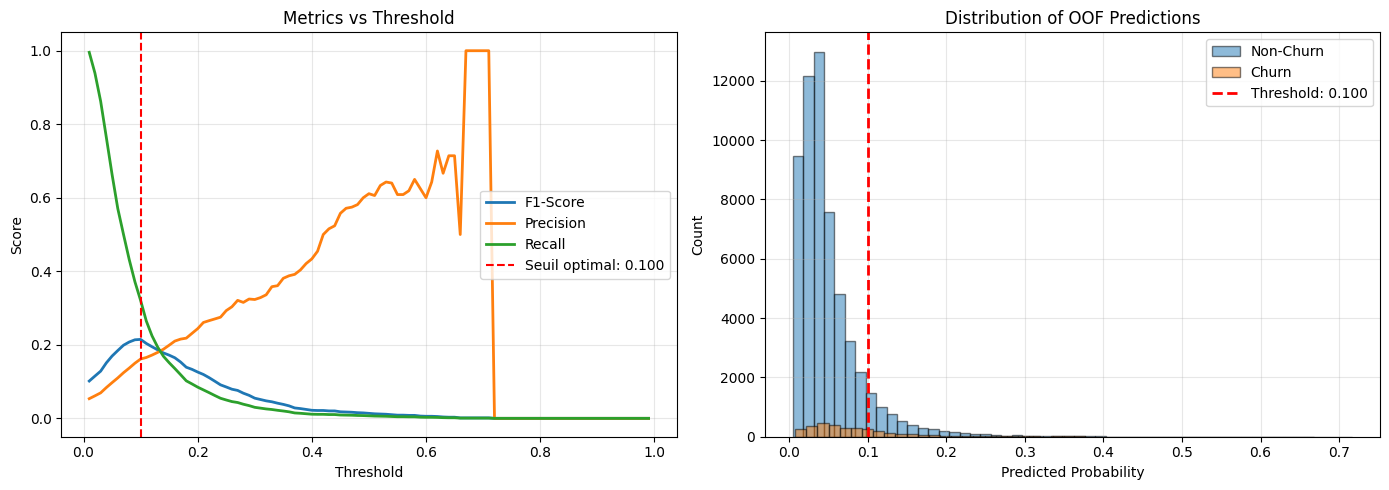

In [ ]:
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_binary = (oof_predictions >= threshold).astype(int)
    f1 = f1_score(y, y_pred_binary)
    f1_scores.append(f1)
    precision_scores.append(precision_score(y, y_pred_binary))
    recall_scores.append(recall_score(y, y_pred_binary))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision_scores[best_idx]
best_recall = recall_scores[best_idx]

print(f"\n✓ Best treshold: {best_threshold:.4f}")
print(f"  F1-Score: {best_f1:.4f}")
print(f"  Precision: {best_precision:.4f}")
print(f"  Recall: {best_recall:.4f}")

y_pred_binary_best = (oof_predictions >= best_threshold).astype(int)
cm = confusion_matrix(y, y_pred_binary_best)
print(f"\nConfusion matrix (threshold={best_threshold:.4f}):")
print(f"  TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"  FN: {cm[1,0]}, TP: {cm[1,1]}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
axes[0].plot(thresholds, precision_scores, label='Precision', linewidth=2)
axes[0].plot(thresholds, recall_scores, label='Recall', linewidth=2)
axes[0].axvline(best_threshold, color='red', linestyle='--', label=f'Seuil optimal: {best_threshold:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Metrics vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(oof_predictions[y==0], bins=50, alpha=0.5, label='Non-Churn', edgecolor='black')
axes[1].hist(oof_predictions[y==1], bins=50, alpha=0.5, label='Churn', edgecolor='black')
axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {best_threshold:.3f}')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of OOF Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
predictions_binary = (predictions >= best_threshold).astype(int)

submission = pd.DataFrame({
    'id': test_features['userId'],
    'target': predictions_binary
})

print(f"\nStatistics of predictions (threshold={best_threshold:.4f}):")
print(f"  Positive predictions (churn): {predictions_binary.sum()} ({predictions_binary.mean()*100:.2f}%)")
print(f"  Negative predictions (non-churn): {(1-predictions_binary).sum()} ({(1-predictions_binary.mean())*100:.2f}%)")
print(f"\nStatistics of raw probabilities:")
print(f"  Min: {predictions.min():.6f}")
print(f"  Max: {predictions.max():.6f}")
print(f"  Mean: {predictions.mean():.6f}")
print(f"  Median: {np.median(predictions):.6f}")

submission_path = 'fifth_submission_binary.csv'
submission.to_csv(submission_path, index=False)

print(f"\n✓ Submission file created: {submission_path}")
print(f"  Shape: {submission.shape}")
print(f"\nPreview:")
print(submission.head(10))


Statistiques des prédictions (seuil=0.1000):
  Prédictions positives (churn): 818 (28.17%)
  Prédictions négatives (non-churn): 2086 (71.83%)

Statistiques des probabilités brutes:
  Min: 0.004788
  Max: 0.778803
  Mean: 0.090693
  Median: 0.062998

✓ Submission file created: fifth_submission_binary.csv
  Shape: (2904, 2)

Preview:
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       1
5  1002397       0
6  1002533       1
7  1002712       1
8  1002879       0
9  1003703       0


## 9. Visualization


DATA:
  - Train: 17499636 events, 19140 users
  - Test: 4393179 events, 2904 users
  - Train period: 2018-10-01 00:00:01 → 2018-11-20 00:00:00
  - Test period: 2018-10-01 00:00:06 → 2018-11-20 00:00:00

TRAINING SNAPSHOTS:
  - Number of snapshots: 4
  - Cutoffs: 2018-10-15 00:00:00 → 2018-11-05 00:00:00
  - Prediction window: 10 days after cutoff
  - Final dataset: 61299 examples
  - Churn rate: 5.23%

FEATURES:
  - Total: 33 features
  - Numeric: 29
  - Categorical: 4
  - Top 3 features: num_thumbsdown, country, percent_nextsong

Cross Validation:
  - ROC-AUC: 0.7214 ± 0.0122
  - PR-AUC: 0.1450 ± 0.0142
  - OOF ROC-AUC: 0.7169
  - OOF PR-AUC: 0.1419

SUBMISSION:
  - File: submission.csv
  - Number of users: 2904
  - Average probability: 0.0907
  - High-risk users (p > 0.2): 249 (8.6%)


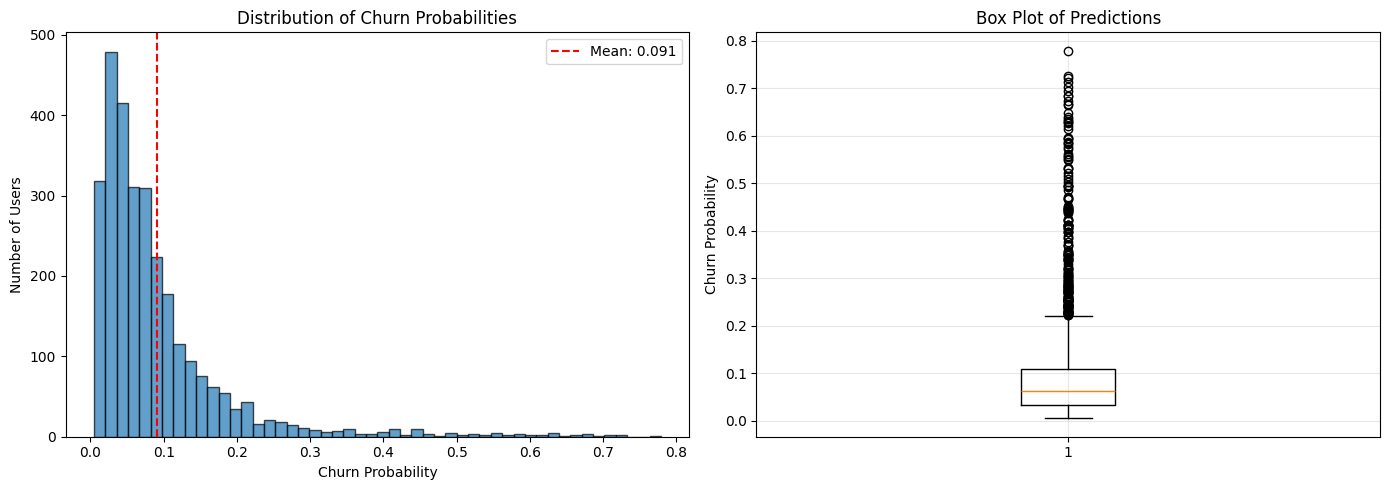

In [ ]:
print("\nDATA:")
print(f"  - Train: {len(train)} events, {train['userId'].nunique()} users")
print(f"  - Test: {len(test)} events, {test['userId'].nunique()} users")
print(f"  - Train period: {train['time'].min()} → {train['time'].max()}")
print(f"  - Test period: {test['time'].min()} → {test['time'].max()}")

print("\nTRAINING SNAPSHOTS:")
print(f"  - Number of snapshots: {len(cutoff_dates)}")
print(f"  - Cutoffs: {cutoff_dates[0]} → {cutoff_dates[-1]}")
print(f"  - Prediction window: 10 days after cutoff")
print(f"  - Final dataset: {len(train_final)} examples")
print(f"  - Churn rate: {train_final['target'].mean()*100:.2f}%")
print("\nFEATURES:")
print(f"  - Total: {len(feature_cols)} features")
print(f"  - Numeric: {len(numeric_cols)}")
print(f"  - Categorical: {len(cat_cols)}")
print(f"  - Top 3 features: {', '.join(feature_importance.head(3)['feature'].values)}")

print("\nCross Validation:")
print(f"  - ROC-AUC: {np.mean(cv_scores_roc):.4f} ± {np.std(cv_scores_roc):.4f}")
print(f"  - PR-AUC: {np.mean(cv_scores_pr):.4f} ± {np.std(cv_scores_pr):.4f}")
print(f"  - OOF ROC-AUC: {oof_roc:.4f}")
print(f"  - OOF PR-AUC: {oof_pr:.4f}")

print("\nSUBMISSION:")
print(f"  - File: submission.csv")
print(f"  - Number of users: {len(submission)}")
print(f"  - Average probability: {predictions.mean():.4f}")
print(f"  - High-risk users (p > 0.2): {(predictions > 0.2).sum()} ({(predictions > 0.2).sum() / len(predictions) * 100:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


axes[0].hist(predictions, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Churn Probability')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('Distribution of Churn Probabilities')
axes[0].axvline(predictions.mean(), color='red', linestyle='--', label=f'Mean: {predictions.mean():.3f}')
axes[0].legend()

# Box plot
axes[1].boxplot(predictions, vert=True)
axes[1].set_ylabel('Churn Probability')
axes[1].set_title('Box Plot of Predictions')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()